#Movie Recommender System

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import required libraries

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from random import randrange
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

pd.options.mode.chained_assignment = None 

In [ ]:
from google.colab import files

uploaded = files.upload() # Here we will upload the csv files for this problem

for fn in uploaded.keys():
  print('You uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving ratings.csv to ratings (1).csv
Saving movies.csv to movies (1).csv
Saving movies_metadata.csv to movies_metadata (1).csv
Saving links.csv to links (6).csv
You uploaded file "ratings.csv" with length 2483723 bytes
You uploaded file "movies.csv" with length 494431 bytes
You uploaded file "movies_metadata.csv" with length 34445126 bytes
You uploaded file "links.csv" with length 197979 bytes


### Input Data Pre-processing

In [ ]:
movies_df = pd.read_csv('movies.csv')
tmdb_df = pd.read_csv('links.csv')
ratings_df = pd.read_csv('ratings.csv')
movies_metadata = pd.read_csv('movies_metadata.csv')

In [ ]:
display(movies_df) 
display(tmdb_df) 

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [ ]:
tmdb_df = pd.merge(movies_df,tmdb_df,on='movieId')
tmdb_df.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [ ]:
display(ratings_df) 
display(movies_metadata) 

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [ ]:
movies_metadata.drop(columns = ['title', 'original_title', 'adult', 'homepage', 'original_language', 'budget', 
                                'belongs_to_collection', 'release_date', 'revenue', 'runtime', 'status', 'video', 
                                'poster_path', 'imdb_id', 'production_countries', 'spoken_languages','vote_average',
                                'vote_count'], inplace = True)
movies_metadata.rename(columns={'id': 'tmdbId'}, inplace=True)

movies_metadata.head()

,genres,tmdbId,overview,popularity,production_companies,tagline
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",NaN
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",Roll the dice and unleash the excitement!
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",Still Yelling. Still Fighting. Still Ready for...
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,Friends are the people who let you be yourself...
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",Just When His World Is Back To Normal... He's ...


In [ ]:
movies_df.drop(columns = ['genres'], inplace = True)
for i in range(len(movies_metadata)):
    try:
        movies_metadata.loc[i, 'tmdbId'] = int(movies_metadata.loc[i, 'tmdbId'])
    except:
        print(i, movies_metadata.loc[i, 'tmdbId'])
movies_metadata = movies_metadata.drop([19730, 29503, 35587])
movies_df = pd.merge(tmdb_df,movies_metadata,on='tmdbId')
movies_df.drop(columns = ['imdbId','tmdbId'], inplace = True)
movies_df.head()

19730 1997-08-20
29503 2012-09-29
35587 2014-01-01


,movieId,title,genres_x,genres_y,overview,popularity,production_companies,tagline
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",NaN
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",Roll the dice and unleash the excitement!
2,3,Grumpier Old Men (1995),Comedy|Romance,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",Still Yelling. Still Fighting. Still Ready for...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,Friends are the people who let you be yourself...
4,5,Father of the Bride Part II (1995),Comedy,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",Just When His World Is Back To Normal... He's ...


In [ ]:
movies_df['tagline'] = movies_df['tagline'].fillna('')
movies_df['overview'] = movies_df['overview'].fillna('')
movies_df['description'] = movies_df['overview'] + movies_df['tagline']
movies_df['description'] = movies_df['description'].fillna('')
movies_df.drop(columns = ['tagline', 'overview'], inplace = True)
movies_df

,movieId,title,genres_x,genres_y,popularity,production_companies,description
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","Led by Woody, Andy's toys live happily in his ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",When siblings Judy and Peter discover an encha...
2,3,Grumpier Old Men (1995),Comedy|Romance,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",A family wedding reignites the ancient feud be...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"Cheated on, mistreated and stepped on, the wom..."
4,5,Father of the Bride Part II (1995),Comedy,"[{'id': 35, 'name': 'Comedy'}]",8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",Just when George Banks has recovered from his ...
...,...,...,...,...,...,...,...
9550,175705,Themroc (1973),Comedy|Horror,"[{'id': 35, 'name': 'Comedy'}]",2.018911,"[{'name': 'Filmanthrope', 'id': 2170}, {'name'...","Made without proper language, just gibberish a..."
9551,175707,A German Life (2016),Documentary,"[{'id': 99, 'name': 'Documentary'}]",0.126064,"[{'name': 'Medienproduktion GmbH', 'id': 85450...","Brunhilde Pomsel describes herself as an ""apol..."
9552,175743,Self-criticism of a Bourgeois Dog (2017),Comedy,"[{'id': 35, 'name': 'Comedy'}]",0.079173,[],A bourgeois dog confesses how he was transform...
9553,175781,Der Herr Karl (1961),Comedy,"[{'id': 35, 'name': 'Comedy'}]",0.192235,"[{'name': 'Österreichischer Rundfunk (ORF)', '...",No overview found.


In [ ]:
ratings_df.drop(columns = ['timestamp'], inplace = True)
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
movies_metadata['tagline'].replace('', np.nan, inplace=True)
movies_metadata.dropna(subset=['tagline'], inplace=True)
movies_metadata['overview'].replace('', np.nan, inplace=True)
movies_metadata.dropna(subset=['overview'], inplace=True)
 
movies_metadata.head()

,genres,tmdbId,overview,popularity,production_companies,tagline
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",Roll the dice and unleash the excitement!
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",Still Yelling. Still Fighting. Still Ready for...
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,Friends are the people who let you be yourself...
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",Just When His World Is Back To Normal... He's ...
5,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",949,"Obsessive master thief, Neil McCauley leads a ...",17.924927,"[{'name': 'Regency Enterprises', 'id': 508}, {...",A Los Angeles Crime Saga


### Making cosine similarity matrix

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_df['description'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
tfidf_matrix2 = tf.fit_transform(movies_df['description'].sample(n=50))
cosine_sim2 = linear_kernel(tfidf_matrix2, tfidf_matrix2)

Correlation of 50 randomly sampled movies


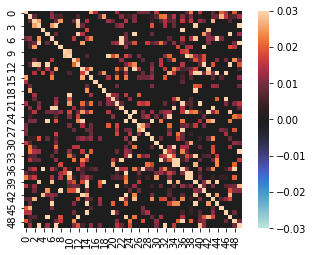

In [ ]:
print('Correlation of 50 randomly sampled movies')
ax = sns.heatmap(
    cosine_sim2, 
    vmin=-0.03, vmax=0.03, center=0,
    square=True
)


### Content based Recommendation System

In [ ]:
titles = movies_df['title']
indices = pd.Series(movies_df.index, index=movies_df['title'])
indices

title
Toy Story (1995)                                   0
Jumanji (1995)                                     1
Grumpier Old Men (1995)                            2
Waiting to Exhale (1995)                           3
Father of the Bride Part II (1995)                 4
                                                ... 
Themroc (1973)                                  9550
A German Life (2016)                            9551
Self-criticism of a Bourgeois Dog (2017)        9552
Der Herr Karl (1961)                            9553
LEGO DC Super Hero Girls: Brain Drain (2017)    9554
Length: 9555, dtype: int64

In [ ]:
def content_recommender(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices], sim_scores

In [ ]:
movieid = int(input("Enter Movie ID: "))

Enter Movie ID: 45


In [ ]:
random_movie = movieid
print('Content based Movie Recommendations for')
print(movies_df.loc[random_movie, 'title'])

rec_titles, rec_scores = content_recommender(random_movie)
print()
for i in range(5):
    print("{} with score: {}".format(rec_titles.iloc[i], rec_scores[i][1]))

Content based Movie Recommendations for
When Night Is Falling (1995)

Two Moon Junction (1988) with score: 0.10765467986100816
Walk on the Moon, A (1999) with score: 0.07257691683192993
Something Wild (1986) with score: 0.06424020888236283
While We're Young (2014) with score: 0.05758958765455134
Carnival of Souls (1962) with score: 0.05514696813148289


### Item based Collaborative Recommender

In [ ]:
df = pd.merge(movies_df,ratings_df,on='movieId')
movie_ratings = pd.DataFrame()
movie_ratings['NumReviews'] = df.groupby('title')['rating'].count()
df = pd.merge(df,movie_ratings,on='title')
movie_ratings['Rating'] = df.groupby('title')['rating'].mean()
movie_ratings.sort_values(['NumReviews'],ascending=False).head()

,NumReviews,Rating
title,,
Forrest Gump (1994),329,4.164134
"Shawshank Redemption, The (1994)",317,4.429022
Pulp Fiction (1994),307,4.197068
"Silence of the Lambs, The (1991)",279,4.161290
"Matrix, The (1999)",278,4.192446


In [ ]:
mean_count = movie_ratings['NumReviews'].mean()
movieRatings = df.query('NumReviews >= @mean_count')
movieRatings.head()

,movieId,title,genres_x,genres_y,popularity,production_companies,description,userId,rating,NumReviews
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","Led by Woody, Andy's toys live happily in his ...",1,4.0,215
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","Led by Woody, Andy's toys live happily in his ...",5,4.0,215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","Led by Woody, Andy's toys live happily in his ...",7,4.5,215
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","Led by Woody, Andy's toys live happily in his ...",15,2.5,215
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","Led by Woody, Andy's toys live happily in his ...",17,4.5,215


In [ ]:
matrix = movieRatings.pivot_table(columns='userId',index='title',values='rating').fillna(0)
matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(500) Days of Summer (2009),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
10 Cloverfield Lane (2016),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
"10,000 BC (2008)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


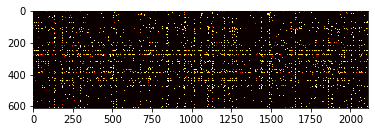

In [ ]:
plt.imshow(matrix.T, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
movie_vectors = csr_matrix(matrix.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'auto') 
model_knn.fit(movie_vectors)

NearestNeighbors(metric='cosine')

In [ ]:
def collab_recommender(random_movie):
    distances, indices = model_knn.kneighbors(matrix.iloc[random_movie,:].values.reshape(1, -1), n_neighbors = 6)
    movies = []
    scores = []
    for i in range(0, len(distances.flatten())):
        if i == 0:
            continue
        else:
            movies.append(matrix.index[indices.flatten()[i]])
            scores.append(distances.flatten()[i])
    return movies, scores

In [ ]:
movieid = int(input("Enter Movie ID: ") )

Enter Movie ID: 67


In [ ]:
random_movie = movieid
print('Recommendations for {0}:\n'.format(matrix.index[random_movie]))
movies, scores = collab_recommender(random_movie)
for i in range(len(movies)):
    print('{}: {}, with distance of {}:'.format(i, movies[i], scores[i]))

Recommendations for Aeon Flux (2005):

0: Ultraviolet (2006), with distance of 0.4153515631365031:
1: Bulletproof Monk (2003), with distance of 0.4562818321019191:
2: Fantastic Four (2005), with distance of 0.4772922904176462:
3: Hellboy (2004), with distance of 0.47821809376993374:
4: Next (2007), with distance of 0.4876110050359935:


### Hybrid Recommender

In [ ]:
def final_recommendations(liked_movies):
    recommendations = []
    for mov in liked_movies:
        movie = -1
        for i in range(len(movies_df)):
            if movies_df.loc[i, 'title'] == mov:
                movie = i
                break
        movs1, scores1 = content_recommender(movie)
        movs1 = movs1.tolist()
        for i in range(len(matrix.index)):
            if matrix.index[i] == mov:
                movie = i
                break
        movs2, scores2 = collab_recommender(movie)
        recommendations.append(movs1[0])
        recommendations.append(movs2[0])
        
    return recommendations

### Testing

In [ ]:
userid = int(input("Enter your User ID: ") )

Enter your User ID: 53


In [ ]:
random_user = userid

liked_movies = matrix.iloc[:, random_user].sort_values(ascending=False).head().index.tolist()
print("User {} likes the movies:".format(random_user))
for m in liked_movies:
    print(m)
rec = final_recommendations(liked_movies)
print("\nMovie Recommendations for User {}:".format(random_user))
rec = list(dict.fromkeys(rec)) # Remove duplicate entries
for r in rec:
    print(r)

User 53 likes the movies:
Silence of the Lambs, The (1991)
Forrest Gump (1994)
Shawshank Redemption, The (1994)
Fugitive, The (1993)
Beauty and the Beast (1991)

Movie Recommendations for User 53:
Red Dragon (2002)
Pulp Fiction (1994)
American Haunting, An (2005)
Shawshank Redemption, The (1994)
Misérables, Les (2012)
Forrest Gump (1994)
Long Goodbye, The (1973)
True Lies (1994)
Beauty and the Beast: The Enchanted Christmas (1997)
Aladdin (1992)
